# Code
...
# Imports

In [7]:
import pandas as pd
from pathlib import Path
import numpy as np
from pathlib import Path
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt


# User Configuration

In [8]:
SAVE_FIGS = True  # Save figures

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

DATA_DIR = Path("../../data")
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="talk",
    palette="colorblind"
)

# Utility Functions

## Data Loading

In [9]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Routine

In [10]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)
num_attrs = df_real.select_dtypes(include=['number']).columns
cat_attrs = df_real.select_dtypes(exclude=['number']).columns

### Diverging Bar Chart
Zur Visualisierung der Abweichungen bei ICD-Diagnosen (Gower-Similarity sehr diskrepant zw. real und synthetisch)

In [11]:
def compare_categorical_distributions(
    real_df: pd.DataFrame,
    synth_df: pd.DataFrame,
    attribute: str,
    top_k: int = 20,
    figsize: Tuple[float, float] = (8, 6),
    cmap_name: str = 'colorblind',
    label: bool = True
) -> Tuple[plt.Figure, plt.Axes, pd.DataFrame]:
    """
    Vergleich der relativen Häufigkeiten einer kategorialen Spalte:
    zeigt die Top-k-Kategorien + 'Other' als Diverging-Bar-Chart.

    Returns
    -------
    fig, ax, freqs_df
      freqs_df enthält die relativen Häufigkeiten (Real vs. Synth)
      für die geplotteten Kategorien.
    """

    # 2) relative Häufigkeiten berechnen
    real_freq  = real_df[attribute].value_counts(normalize=True)
    synth_freq = synth_df[attribute].value_counts(normalize=True)

    # 3) Top-k nach absoluter Differenz auswählen
    diff = (real_freq.subtract(synth_freq, fill_value=0)
                      .abs()
                      .sort_values(ascending=False))
    top_cats = list(diff.index[:top_k])

    # 4) 'Other' berechnen und anhängen
    def select_and_add_other(freqs: pd.Series, cats: list) -> pd.Series:
        sel = freqs.reindex(cats, fill_value=0).copy()
        sel['Other'] = 1.0 - sel.sum()
        return sel

    real_sel  = select_and_add_other(real_freq,  top_cats)
    synth_sel = select_and_add_other(synth_freq, top_cats)

    # 5) DataFrame zum Plotten aufbauen
    df_plot = pd.DataFrame({
        'Real': real_sel,
        'Synthetic': synth_sel
    })
    df_plot['Diff'] = df_plot['Real'] - df_plot['Synthetic']
    df_plot = df_plot.sort_values('Diff')  # für geordnete Anzeige

    # 6) Plot erstellen
    fig, ax = plt.subplots(figsize=figsize)
    # Diverging Bar Chart: Diff-Werte horizontal
    bars = ax.barh(
        y=df_plot.index,
        width=df_plot['Diff'],
        height=0.8,
        zorder=2
    )
    ax.axvline(0, color='black', linewidth=0.8)

    # Farben aus einem Seaborn-Cycle
    palette = sns.color_palette(cmap_name, 2)
    for bar in bars:
        bar.set_color(palette[0] if bar.get_width() >= 0 else palette[1])

    # 7) Annotationen
    if label:
        ax.text(
            0.95, 0.15,
            'More frequent in →\nthe real dataset →',
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=10, style='italic'
        )
        ax.text(
            0.15, 0.75,
            '← More frequent in\n← the synthetic dataset',
            transform=ax.transAxes,
            ha='left', va='top',
            fontsize=10, style='italic'
        )

    ax.set_xlabel('Differenz (Real - Synthetic)')
    ax.set_ylabel(attribute.capitalize())
    ax.set_title(f'{attribute}', fontsize=12)

    plt.tight_layout()
    return fig, ax, df_plot[['Real', 'Synthetic']]


In [14]:
# df_real.head()
df_real['night_arrival'].value_counts(normalize=True)

night_arrival
False    0.812875
True     0.187125
Name: proportion, dtype: float64

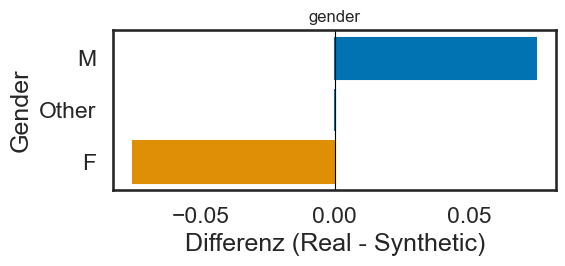

In [16]:
# attr = 'icd_block'
# attr = 'chief_complaint'
# attr = 'consciousness_level'
# attr = 'ethnicity'
attr = 'gender'
# attr = 'night_arrival'



fig, ax, freqs = compare_categorical_distributions(
    df_real, df_synth, attribute=attr, top_k=20, figsize=(6, 3), label = False
)
plt.show()
if SAVE_FIGS:
    fig.savefig(OUTPUT_DIR_FIG / f'{attr}_diverging-bar-chart.tiff', dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)